# İlk embedding’iniz

## Egzersiz hedefleri:

- NLP için ilk RNN'nizi çalıştırın
- Gömme kavramının ne olduğunu ilk kez deneyimleyin

<hr>

Kelimeler, sinir ağına kolayca besleyebileceğiniz şeyler değildir. Bu nedenle, onları daha anlamlı bir şeye dönüştürmemiz gerekir. 

Ve _Embeddings_ kavramı tam da bunun için vardır! Herhangi bir kelimeyi vektörel bir temsil üzerine eşler (bu, her kelimeyi bir vektörle temsil etmenin süslü bir yoludur ;) ). Örneğin, `köpek` kelimesi gömme uzayında $(w_1, w_2, ..., w_n)$ vektörü ile temsil edilebilir ve biz de $(w_k)_k$ ağırlıklarını öğreniriz.

Öyleyse haydi başlayalım.

# Data

❓ **Soru** ❓ Öncelikle verileri yükleyelim. Fonksiyonda neler olduğunu anlamanıza gerek yok, burada önemi yok.

⚠️ **Uyarı** ⚠️ `load_data` fonksiyonunun bir `percentage_of_sentences` argümanı vardır. Bilgisayarınıza bağlı olarak, çok fazla cümle bilgisayarınızı yavaşlatabilir veya hatta dondurabilir - RAM'iniz taşabilir. Bu nedenle, **cümlelerin %10'uyla başlamalı** ve bilgisayarınızın bunu kaldırabildiğini görmelisiniz. Aksi takdirde, daha düşük bir sayı ile yeniden çalıştırın. 

⚠️ **DISCLAIMER** ⚠️ **_En büyüğü kimde_ (RAM) oyununu oynamaya gerek yok!** Buradaki amaç, modellerinizi hızlı bir şekilde çalıştırarak prototip oluşturmaktır. Gerçek hayatta bile, hızlı bir şekilde döngü ve hata ayıklama yapmak için verilerinizin bir alt kümesiyle başlamanız önerilir. Bu nedenle, yalnızca en iyi doğruluğu elde etmek istiyorsanız sayıyı artırın. 

In [2]:
#####################################################
### Verileri yüklemek için bu hücreyi çalıştırın  ###
#####################################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Tüm verilerin yalnızca belirli bir yüzdesini alın
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

Verileri yüklediğinize göre, şimdi bir göz atalım!

❓ **Soru** ❓ Burada verilerle oynayabilirsiniz. Özellikle, `X_train` ve `X_test` cümle listeleridir. Bunlardan bazılarını, `y_train` ve `y_test` içinde saklanan ilgili etiketleriyle birlikte yazdırın.

In [3]:
# X_train: list[list[str]]  -> her yorum kelime listesi
# y_train: 0 (neg) / 1 (pos)

for i in range(5):
    label = "pos" if y_train[i] == 1 else "neg"
    print(f"Örnek {i} | label={y_train[i]} ({label})")
    print(" ".join(X_train[i][:40]), "...")  # ilk 40 kelimeyi göster
    print("-" * 80)

Örnek 0 | label=0 (neg)
this was an absolutely terrible movie don't be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous ...
--------------------------------------------------------------------------------
Örnek 1 | label=0 (neg)
i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occasion i ...
--------------------------------------------------------------------------------
Örnek 2 | label=0 (neg)
mann photographs the alberta rocky mountains in a superb fashion and jimmy stewart and walter brennan give enjoyable performances as they always seem to do br br but come on hollywood a mountie telling the people of dawson city yukon ...
--------------------------------------------------------------------

**ETİKETLER**: Görev bir ikili sınıflandırma problemidir:
- etiket 0️⃣ <font color=red>negatif</font> film yorumuna karşılık gelir
- etiket 1️⃣ <font color=green>pozitif</font> film yorumuna karşılık gelir

**GİRDİLER**:
- 🧹 Veri kısmen temizlenmiştir! Bu yüzden bu egzersizde bununla ilgilenmenize gerek yok.
- ❗️ Ancak gerçek hayattaki çalışmalarda bu adımı unutmamalısınız.

Kelimelerin bilgisayarlar için doğrudan uygun olmadığını hatırlıyor musunuz?  
Onları **tokenize** etmeniz gerekir!

❓ **Soru** ❓ Aşağıdaki hücreyi çalıştırarak cümlelerinizi tokenize edin

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Bu, tüm tokenizasyonu sizin için yapan bir Keras yardımcı programını başlatır.
tokenizer = Tokenizer()

# Tokenizasyon, bir tokeni (integer) her kelimeye eşleyen bir sözlüğü öğrenir.
# Bu, yalnızca eğitim setinde yapılabilir - test setini bilmemiz gerekmez!
# Bu tokenizasyon ayrıca kelimelerinizi küçük harfe çevirir, bazı filtreler uygular vb. - isterseniz dokümanı kontrol edebilirsiniz.
tokenizer.fit_on_texts(X_train)

# Tokenizasyonu eğitim ve test setine uygularız.
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

❓ **Soru** ❓ Beklediğiniz sonucu aldığınızdan emin olmak için tokenize edilmiş cümlelerin bazılarını yazdırın.

In [5]:
for i in range(3):
    print(f"Orijinal kelimeler (ilk 15): {X_train[i][:15]}")
    print(f"Token id'ler (ilk 15):     {X_train_token[i][:15]}")
    print("-" * 80)

Orijinal kelimeler (ilk 15): ['this', 'was', 'an', 'absolutely', 'terrible', 'movie', "don't", 'be', 'lured', 'in', 'by', 'christopher', 'walken', 'or', 'michael']
Token id'ler (ilk 15):     [11, 13, 33, 422, 402, 18, 91, 27, 6893, 8, 31, 1311, 4504, 39, 539]
--------------------------------------------------------------------------------
Orijinal kelimeler (ilk 15): ['i', 'have', 'been', 'known', 'to', 'fall', 'asleep', 'during', 'films', 'but', 'this', 'is', 'usually', 'due', 'to']
Token id'ler (ilk 15):     [9, 25, 76, 572, 5, 730, 1945, 296, 100, 17, 11, 6, 625, 662, 5]
--------------------------------------------------------------------------------
Orijinal kelimeler (ilk 15): ['mann', 'photographs', 'the', 'alberta', 'rocky', 'mountains', 'in', 'a', 'superb', 'fashion', 'and', 'jimmy', 'stewart', 'and', 'walter']
Token id'ler (ilk 15):     [2445, 6894, 1, 12119, 3232, 2898, 8, 2, 1008, 1602, 3, 1879, 904, 3, 1697]
------------------------------------------------------------------

Her kelimeyi bir token ile eşleştiren sözlüğe `tokenizer.word_index` ile erişilebilir.

❓ **Soru** ❓ Eğitim setindeki farklı kelimelerin (=tokenlerin) sayısını depolayan bir `vocab_size` değişkeni ekleyin. Buna _sözcük dağarcığının boyutu_ (_size of the vocabulary_) denir.

In [6]:
vocab_size = len(tokenizer.word_index)
print("Vocabulary size (eğitim setindeki farklı kelime sayısı):", vocab_size)

Vocabulary size (eğitim setindeki farklı kelime sayısı): 30419


`X_train_token` ve `X_test_token` farklı uzunluklarda diziler içerir.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/NLP/padding.png" alt='Padding example' width="700px" />

Ancak, bir sinir ağı girdi olarak bir tensör içermelidir. Bu nedenle, verilerinizi doldurmanız gerekir.

❓ **Soru** ❓  Verilerinizi `pad_sequences` işleviyle doldurun (belgeler [burada](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)). `dtype` ve `padding` anahtar kelimelerini unutmayın (ancak burada `maxlen` kullanmayın).

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_token, dtype="int32", padding="post")
X_test_pad  = pad_sequences(X_test_token,  dtype="int32", padding="post")

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape :", X_test_pad.shape)

X_train_pad shape: (2500, 1164)
X_test_pad shape : (2500, 988)


# RNN

Şimdi bu verileri Tekrarlayan Sinir Ağına aktaralım.

❓ **Soru** ❓ Aşağıdakileri içeren bir model yazın:
- `input_dim` değeri kelime dağarcığınızın boyutu (= `vocab_size`) olan ve `output_dim` değeri istediğiniz gömme alanının boyutu olan bir gömme katmanı
- bir RNN (SimpleRNN, LSTM, GRU) katmanı
- bir Yoğun katman
- bir çıktı katmanı

⚠️ **Uyarı** ⚠️ Burada maskeleme katmanına ihtiyacınız yoktur. Neden? Çünkü `layers.Embedding` bunu doğrudan yapmak için bir argümana sahiptir ve bunu `mask_zero=True` ile ayarlamanız gerekir. Bu aynı zamanda verilerinizin **0** ile doldurulması **GEREKTİĞİ** anlamına gelir (bu varsayılan davranıştır). Bunun `input_dim`'i nasıl **etkilediğini** anlamak için [belgelere](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) bakın.

<details>
    <summary>💡İpucu</summary>

`input_dim` kelime dağarcığının büyüklüğü + 1'e eşit olmalıdır

</details>

Uygun argümanlarla derleyin.

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

embedding_dim = 64
rnn_units = 64

seq_len = X_train_pad.shape[1]  # pad sonrası sequence uzunluğu

model = models.Sequential([
    tf.keras.Input(shape=(seq_len,), dtype="int32"),   # <-- kritik: modeli build eder
    layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, mask_zero=True),
    layers.GRU(rnn_units),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1164, 64)       │     1,946,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,973,953 (7.53 MB)

 Trainable params: 1,973,953 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

❓ **Soru** ❓ RNN'nizdeki parametre sayısına bakın. 

In [13]:
rnn_params = model.layers[1].count_params()
print("RNN layer param count:", rnn_params)

RNN layer param count: 24960


❓ Gömme katmanınızdaki parametre sayısının (kelime dağarcığınızdaki kelime sayısı + maskeleme değeri için 1) $\times$ gömme boyutunuzla eşit olduğunu iki kez kontrol edin.

In [14]:
embedding_params = model.layers[0].count_params()
expected = (vocab_size + 1) * embedding_dim

print("Embedding params (model):", embedding_params)
print("Expected params:", expected)
print("Eşit mi?", embedding_params == expected)

Embedding params (model): 1946880
Expected params: 1946880
Eşit mi? True


❓ **Soru** ❓ Modelinizi 20 dönemle ve sabır değeri 4 olan erken durdurma kriteriyle uyumlaştırmaya başlayın.

⚠️ **Uyarı** ⚠️ Bunun çok zaman aldığını görebilirsiniz! 

**Bu yüzden birkaç yinelemeden sonra durdurun!**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print("Test accuracy:", test_acc)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 827ms/step - accuracy: 0.5320 - loss: 0.6919 - val_accuracy: 0.6220 - val_loss: 0.6846
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 771ms/step - accuracy: 0.7155 - loss: 0.6233 - val_accuracy: 0.7120 - val_loss: 0.5947
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 834ms/step - accuracy: 0.8795 - loss: 0.3042 - val_accuracy: 0.7240 - val_loss: 0.5965
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9680 - loss: 0.0920 - val_accuracy: 0.7060 - val_loss: 0.7532
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9815 - loss: 0.0659 - val_accuracy: 0.7580 - val_loss: 1.4822
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9870 - loss: 0.0375 - val_accuracy: 0.7100 - val_loss: 0.9672
Test accuracy: 0.6700000166893005


Ekrana bakarak veya kahve içerek çok fazla zaman kaybetmeyelim. Ara vermeye başlamak için henüz çok erken ;)

❓ **Soru** ❓ Hesaplama süresini kısaltacağız. Başlangıç olarak, tren setinizin farklı cümlelerinde kaç kelime olduğunu görelim (aşağıdaki hücreyi çalıştırın).

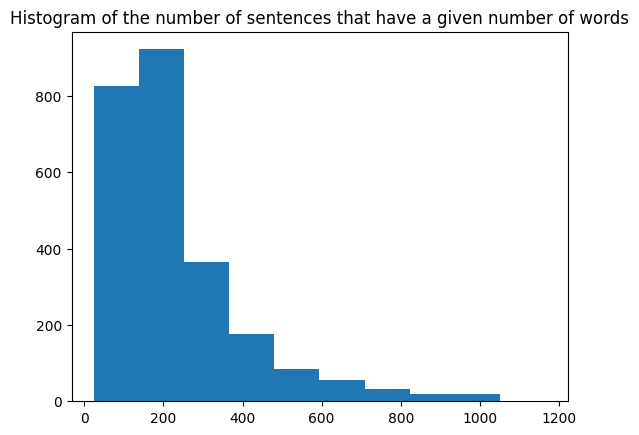

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()

plot_hist(X_train)

Muhtemelen cümlelerinizin %90 ila %95'inin 300 kelimeden az olduğunu göreceksiniz. Ve çok azı 1000 kelimeden fazladır.

Ancak, yukarıdaki dolguda `maxlen` kullanmadığınız için, girdi tensörünüzün boyutu, en fazla kelimeye sahip cümlenin uzunluğuna eşittir.

Şimdi, bunun dolguyu nasıl etkilediğine bakalım: 


<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/NLP/tensor_size.png" alt='Dimensions of the tensor' width="700px" />

Birkaç çok uzun cümle nedeniyle, tensörünüzün bir boyutu yaklaşık 1000'e eşittir. Ancak, ~200 kelimelik cümlelerin çoğu, işe yaramayan dolgu değerlerine sahiptir.

Dolayısıyla, tensörünüz çoğunlukla işe yaramayan bilgilerden oluşur ve bu da eğitim sürecine zaman ekler.

Peki, verileri maksimum uzunluk (`maxlen`) olarak örneğin 200 (kelime) olacak şekilde doldurursanız ne olur?
- İlk olarak, bu yakınsamayı artıracak ve algoritmanın yakınsamayı beklerken ekrana bakmanıza gerek kalmayacaktır.
- Ancak esasen, gerçekten bu kadar çok bilgiyi kaybediyor musunuz? Bir cümlenin olumlu mu olumsuz mu olduğunu anlamak için genellikle 200 kelimeden (1000'e kadar) fazlasına ihtiyaç duyduğunuzu düşünüyor musunuz?

❓ **Soru** ❓ Tüm bu nedenlerden dolayı, `maxlen` anahtar kelimesini kullanarak dolguyu yeniden yapın ve modeli yeniden eğitin!  Performansı düşürmeden, şimdi ne kadar hızlı olduğunu görün ;)

In [19]:
from time import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

maxlen = 200

X_train_pad_200 = pad_sequences(X_train_token, maxlen=maxlen, dtype="int32", padding="post", truncating="post")
X_test_pad_200  = pad_sequences(X_test_token,  maxlen=maxlen, dtype="int32", padding="post", truncating="post")

print("X_train_pad_200 shape:", X_train_pad_200.shape)
print("X_test_pad_200 shape :", X_test_pad_200.shape)

model_fast = models.Sequential([
    layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, mask_zero=True),
    layers.GRU(rnn_units),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_fast.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

t0 = time()
history_fast = model_fast.fit(
    X_train_pad_200, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
t1 = time()

test_loss_fast, test_acc_fast = model_fast.evaluate(X_test_pad_200, y_test, verbose=0)
print("Test accuracy (maxlen=200):", test_acc_fast)
print("Training time (sec):", round(t1 - t0, 2))

X_train_pad_200 shape: (2500, 200)
X_test_pad_200 shape : (2500, 200)
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.5210 - loss: 0.6926 - val_accuracy: 0.5160 - val_loss: 0.6920
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7310 - loss: 0.6539 - val_accuracy: 0.7140 - val_loss: 0.5606
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.8610 - loss: 0.3413 - val_accuracy: 0.7680 - val_loss: 0.6799
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.9695 - loss: 0.0894 - val_accuracy: 0.7860 - val_loss: 0.8285
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.7960 - val_loss: 0.7991
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.7420 - val_loss: 1.0612
Test accuracy (maxlen=200): 0.6919999718666077
Training time (sec): 37.98


🏁 Harika, artık `Tokenizer` ve `pad_sequences` kullanabilirsiniz.

💾 Not defterinizi git add/commit/push yapmayı unutmayın...

🚀 ... ve bir sonraki göreve geçin!